In [259]:
from preprocess import Parser
from classifier import DiscriminativeClassifier, BinaryGenerativeClassifier
from evaluation import calc_sd_auc, correlate_AUCs, calc_z_diff
import pandas as pd
from io import StringIO
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk import word_tokenize
import nltk
import re
import operator
from topicmodel import LDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_table(StringIO(''.join(l.replace('\u2028', ' ') for l in open('minutes_data.txt'))))
data.head()

,meeting,text,seq,D_NBER
0,197601,"By unanimous vote, the Federal Reserve Bank o...",0,0
1,197601,"Committee, to execute transactions in the Sys...",1,0
2,197601,The information reviewed at this meeting sugg...,2,0
3,197601,"sales rose sharply, but the increase in the f...",3,0
4,197601,The exchange value of the dollar against lead...,4,0


In [3]:
grouped_data = data.groupby('meeting', as_index=False)
full_minutes = pd.concat([grouped_data['text'].apply(' '.join), grouped_data.first()], axis=1)
full_minutes.drop(['text', 'seq'], axis=1, inplace=True)
full_minutes.rename(columns={0: 'text'}, inplace=True)
full_minutes.head()

,text,meeting,D_NBER
0,"By unanimous vote, the Federal Reserve Bank o...",197601,0
1,"By unanimous vote, the Federal Reserve Bank o...",197602,0
2,"By unanimous vote, the Federal Reserve Bank o...",197603,0
3,"By unanimous vote, the Federal Reserve Bank o...",197604,0
4,"With Mr. Coldwell, dissenting, the Federal Re...",197605,0


In [104]:
# train, validate = train_test_split(full_minutes, test_size=0.2)
train, test = train_test_split(full_minutes, test_size=122)

In [155]:
test['D_NBER'].value_counts()

0    101
1     21
Name: D_NBER, dtype: int64

In [106]:
parser = Parser(lemmatise=False, stem=True, replace_ngrams=False)

In [107]:
full_docs, vocab = parser.parse_vocab(full_minutes['text'])
full_corpus = parser.parse_corpus(full_docs, vocab)

Successfully parsed the corpus. # docs:  322
Vocabulary size, # tokens:  4202


In [108]:
docs, vocab = parser.parse_vocab(train['text'])

In [109]:
train_corpus = parser.parse_corpus(docs, vocab)

Successfully parsed the corpus. # docs:  200
Vocabulary size, # tokens:  3776


In [110]:
# grouped_data = validate.groupby('meeting', as_index=False)
# validation_data = pd.concat([grouped_data['text'].apply(' '.join), grouped_data.first()], axis=1)
# validation_data.drop(['text', 'seq'], axis=1, inplace=True)
# validation_data.rename(columns={0: 'text'}, inplace=True)

test_docs, _ = parser.parse_vocab(test['text'])
test_corpus = parser.parse_corpus(test_docs, vocab)

Successfully parsed the corpus. # docs:  122
Vocabulary size, # tokens:  3776


In [111]:
topic_model = LDA(K=50, alpha=1, eta=0.01)

In [112]:
theta_train, beta, elbo = topic_model.fit_multiple_runs(train_corpus, vocab, max_iter=100, verbose=False)

Learning completed!
Total time taken: 37s
ELBO = -1932407.230804


In [113]:
theta_test, _ = topic_model.infer(test_corpus)

In [264]:
model = LogisticRegressionCV()
model.fit(theta_train, train['D_NBER'])


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [265]:
prediction = model.predict(theta_test)

In [266]:
accuracy_score(test['D_NBER'], prediction)

0.88524590163934425

In [267]:
roc_auc_score(test['D_NBER'], model.predict_proba(theta_test)[:, 1])

0.94625176803394628

In [120]:
pd.DataFrame(theta_train).to_csv('theta_train_random_split.csv', index=False)
pd.DataFrame(theta_test).to_csv('theta_test_random_split.csv', index=False)

In [157]:
calc_sd_auc(0.94625176803394628, 101, 21)

0.02750707137365724

# generative

In [121]:
recession = train[train['D_NBER'] == 1]
growth = train[train['D_NBER'] == 0]

In [122]:
docs_rec, _ = parser.parse_vocab(recession['text'])
train_corpus_rec = parser.parse_corpus(docs_rec, vocab)
# v_docs_rec, _ = parser.parse_vocab(validate['text'])
# validation_corpus = parser.parse_corpus(validation_docs, vocab)

docs_g, _ = parser.parse_vocab(growth['text'])
train_corpus_g = parser.parse_corpus(docs_g, vocab)

Successfully parsed the corpus. # docs:  18
Vocabulary size, # tokens:  3776
Successfully parsed the corpus. # docs:  182
Vocabulary size, # tokens:  3776


In [123]:
model_recession = LDA(K=50, alpha=1, eta=0.01)
model_growth = LDA(K=50, alpha=1, eta=0.01)

In [124]:
theta_train_rec, beta_rec, elbo_rec = model_recession.fit(train_corpus_rec, vocab, max_iter=300, verbose=False)

Learning completed!
Total time taken: 14s
ELBO = -163346.598357


In [125]:
theta_train_g, beta_g, elbo_g = model_growth.fit(train_corpus_g, vocab, max_iter=300, verbose=False)

Learning completed!
Total time taken: 89s
ELBO = -1768777.484254


In [127]:
theta_test_rec, _ = model_recession.infer(test_corpus)

In [128]:
theta_test_g, _ = model_growth.infer(test_corpus)

In [148]:
# from scipy.misc import logsumexp

# priors = [0.86, 0.14]
# doc_term_ids = test_corpus[0]
# doc_term_counts = test_corpus[1]

# assert len(doc_term_ids) == len(doc_term_counts)
# num_docs = len(doc_term_ids)

# doc_probs = []
# for d in range(num_docs):
#     one_doc_term_ids = doc_term_ids[d]
#     one_doc_term_counts = doc_term_counts[d]

#     theta_doc_model_1 = theta_test_g[d, :]
#     beta_doc_model_1 = beta_g[:, one_doc_term_ids]
#     words_prob_model_1 = np.dot(theta_doc_model_1, beta_doc_model_1) * one_doc_term_counts
#     # log[P(model 1 | doc)]
#     logp_model_1 = np.sum(np.log(words_prob_model_1)) + np.log(priors[0])

#     theta_doc_model_2 = theta_test_rec[d, :]
#     beta_doc_model_2 = beta_rec[:, one_doc_term_ids]
#     words_prob_model_2 = np.dot(theta_doc_model_2, beta_doc_model_2) * one_doc_term_counts
#     # log[P(model 2 | doc)]
#     logp_model_2 = np.sum(np.log(words_prob_model_2)) + np.log(priors[1])

#     log_probs = np.array([logp_model_1, logp_model_2])

#     probabilities = np.exp(log_probs - logsumexp(log_probs))

#     doc_probs.append(probabilities)

# preds = list(map(lambda x: 0 if np.argmax(x) == 0 else 1, doc_probs))

In [138]:
gen_classifier = BinaryGenerativeClassifier(model_growth, model_recession, beta_g, beta_rec)

A generative classifier is initialised.


In [143]:
doc_probs = gen_classifier.predict_proba(test_corpus, priors=[0.83, 0.17])
preds = list(map(lambda x: 0 if np.argmax(x) == 0 else 1, doc_probs))

In [149]:
roc_auc_score(test['D_NBER'], list(map(lambda x: x[1], doc_probs)))

0.93870815652993866

In [150]:
pd.DataFrame(theta_train_g).to_csv('theta_train_growth.csv', index=False)
pd.DataFrame(theta_train_rec).to_csv('theta_train_recession.csv', index=False)
pd.DataFrame(theta_test_g).to_csv('theta_test_growth.csv', index=False)
pd.DataFrame(theta_test_rec).to_csv('theta_test_recession.csv', index=False)

pd.DataFrame(beta_g).to_csv('beta_train_growth.csv', index=False)
pd.DataFrame(beta_rec).to_csv('beta_train_recession.csv', index=False)




In [156]:
calc_sd_auc(0.93870815652993866, 101, 21)

0.028359297000323736

In [176]:
n0, n1 = test['D_NBER'].value_counts()
AUC_A = roc_auc_score(test['D_NBER'], model.predict_proba(theta_test)[:, 1])
AUC_B = roc_auc_score(test['D_NBER'], list(map(lambda x: x[1], doc_probs)))

sd_A = calc_sd_auc(AUC_A, n0, n1)
sd_B = calc_sd_auc(AUC_B, n0, n1)

recession_idx = np.array(np.where(test['D_NBER']==1)[0], dtype=np.int)

recession_probs_A = model.predict_proba(theta_test)[:, 1]
recession_probs_B = list(map(lambda x: x[1], doc_probs))

corr_A_B = correlate_AUCs(AUC_A, AUC_B,
                         recession_probs_A,
                         recession_probs_B,
                         recession_idx)

z_stat = calc_z_diff(AUC_A, AUC_B, sd_A, sd_B, corr_A_B)

print(z_stat)

0.397115109118


# Nowcast

In [177]:
train_set = full_minutes[:200]
test_set = full_minutes[200:]

In [178]:
recession_docs = train_set[train_set['D_NBER'] == 1]
growth_docs = train_set[train_set['D_NBER'] == 0]

In [179]:
docs_rec, _ = parser.parse_vocab(recession_docs['text'])
train_corpus_rec = parser.parse_corpus(docs_rec, vocab)
# v_docs_rec, _ = parser.parse_vocab(validate['text'])
# validation_corpus = parser.parse_corpus(validation_docs, vocab)

docs_g, _ = parser.parse_vocab(growth_docs['text'])
train_corpus_g = parser.parse_corpus(docs_g, vocab)

Successfully parsed the corpus. # docs:  22
Vocabulary size, # tokens:  3776
Successfully parsed the corpus. # docs:  178
Vocabulary size, # tokens:  3776


In [188]:
test_docs, _ = parser.parse_vocab(test_set['text'])
test_corpus = parser.parse_corpus(test_docs, vocab)

Successfully parsed the corpus. # docs:  122
Vocabulary size, # tokens:  3776


In [180]:
nowcast_recession = LDA(K=50, alpha=1, eta=0.01)
nowcast_growth = LDA(K=50, alpha=1, eta=0.01)

In [181]:
theta_nowcast_rec, beta_nowcast_rec, elbo_rec = nowcast_recession.fit(train_corpus_rec, vocab, max_iter=300, verbose=False)

Learning completed!
Total time taken: 10s
ELBO = -41661.105978


In [182]:
theta_nowcast_g, beta_nowcast_g, elbo_g = nowcast_growth.fit(train_corpus_g, vocab, max_iter=300, verbose=False)

Learning completed!
Total time taken: 69s
ELBO = -952454.039859


In [189]:
theta_test_nowcast_rec, _ = nowcast_recession.infer(test_corpus)
theta_test_nowcast_g, _ = nowcast_growth.infer(test_corpus)

In [187]:
gen_nowcaster = BinaryGenerativeClassifier(nowcast_growth, nowcast_recession, beta_nowcast_g, beta_nowcast_rec)

A generative classifier is initialised.


In [192]:
nowcast_probs = gen_classifier.predict_proba(test_corpus, priors=[0.86, 0.14])
nowcast_preds = list(map(lambda x: 0 if np.argmax(x) == 0 else 1, nowcast_probs))

roc_auc_score(test_set['D_NBER'], list(map(lambda x: x[1], nowcast_probs)))

0.84285714285714286

In [193]:
calc_sd_auc(0.84285714285714286, 105, 17)

0.03810903434441655

In [200]:
discriminative_nowcast_predictions = pd.read_csv('discr_nowcast_preds.csv')

In [243]:
n0, n1 = test_set['D_NBER'].value_counts()
AUC_A = 0.872
AUC_B = roc_auc_score(test_set['D_NBER'], list(map(lambda x: x[1], nowcast_probs)))

sd_A = calc_sd_auc(AUC_A, n0, n1)
sd_B = calc_sd_auc(AUC_B, n0, n1)

recession_idx = np.array(np.where(test_set['D_NBER']==1)[0], dtype=np.int)

recession_probs_A = discriminative_nowcast_predictions['p1']
recession_probs_B = list(map(lambda x: x[1], nowcast_probs))

corr_A_B = correlate_AUCs(AUC_A, AUC_B,
                         recession_probs_A,
                         recession_probs_B,
                         recession_idx)
if np.isnan(corr_A_B):
    corr_A_B = 0 # one array may have zero variance

z_stat = calc_z_diff(AUC_A, AUC_B, sd_A, sd_B, corr_A_B)

print(z_stat)

0.551504266055


/Users/dkn22/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [ ]:
pd.DataFrame(theta_nowcast_g).to_csv('theta_nowcast_growth.csv', index=False)
pd.DataFrame(theta_nowcast_rec).to_csv('theta_nowcast_recession.csv', index=False)
pd.DataFrame(theta_test_nowcast_g).to_csv('theta_test_nowcast_growth.csv', index=False)
pd.DataFrame(theta_test_nowcast_rec).to_csv('theta_test_nowcast_recession.csv', index=False)

pd.DataFrame(beta_nowcast_g).to_csv('beta_nowcast_growth.csv', index=False)
pd.DataFrame(beta_nowcast_rec).to_csv('beta_nowcast_recession.csv', index=False)

pd.DataFrame(nowcast_probs).to_csv('gen_classifier_probs.csv', index=False)


In [279]:
confusion_matrix(test_set['D_NBER'], np.array(recession_probs_B) > 0.99)

array([[60, 45],
       [ 0, 17]])

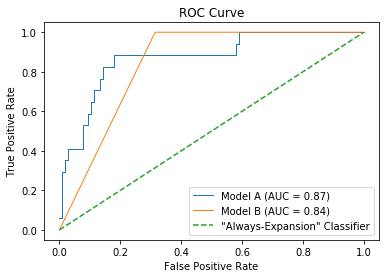

In [261]:
predictions = {'Model A': recession_probs_A,
              'Model B': recession_probs_B}

# plt.figure(figsize=(15,8))
for model, preds in predictions.items():
    fpr, tpr, thresholds = roc_curve(test_set['D_NBER'], preds) 
    roc_auc = auc(fpr, tpr)
        
    plt.plot(fpr, tpr, lw=1, label = model + ' (AUC = %.2f)' %(roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', label='"Always-Expansion" Classifier')
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC Curve')
plt.legend(frameon=True, loc='lower right')
plt.savefig('roc_curve.png', format='png', dpi=600, transparent=False,
           bbox_inches='tight')
plt.show()

In [275]:
accuracy_score(test_set['D_NBER'], np.array(recession_probs_B) > 0.9)

0.62295081967213117